In [1]:
import sys 

import sklearn
import numpy as np 
import os
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.utils import io

from sklearn.model_selection import train_test_split

# Loading the data


In [2]:
df_train = pd.read_csv("./data/mnist/fashion-mnist_train.csv")
df_test = pd.read_csv("./data/mnist/fashion-mnist_test.csv")

y_train_full = df_train.label
y_test = df_test.label

x_train_full = df_train.drop("label", axis=1).to_numpy()
x_test = df_test.drop("label", axis=1).to_numpy()

x_train,x_validate,y_train,y_validate = train_test_split(x_train_full,y_train_full)


# dim reduction
We want to find the best possible number of componentes that will give us the maximum value for the minimum number of featuers

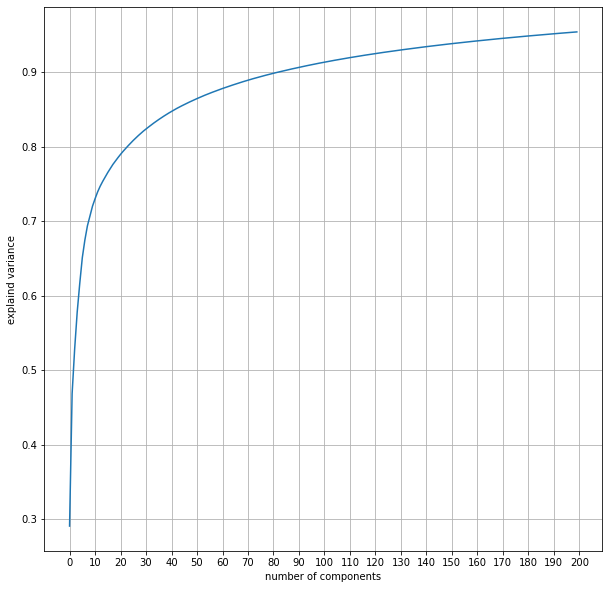

In [3]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_[:200])

plt.figure(figsize=(10,10))
plt.plot(cumsum)
plt.xlabel("number of components")
plt.ylabel("explaind variance")
plt.grid(True)
plt.xticks(range(0,210,10))
plt.show()


We can see we have an elbow between 10-40 components, so in that area we will get the most accuracy with the minimum number of featuers.

We will go with 40 components for now.

now,Lets see how much data our pca algorithm loses:

In [4]:
def plot_pictures(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")



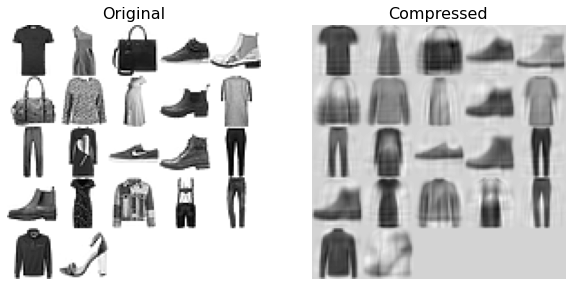

In [5]:
pca = PCA(n_components=40)
x_reducerd = pca.fit_transform(x_train)
x_recovered = pca.inverse_transform(x_reducerd)

with io.capture_output() as captured:
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plot_pictures(x_train[::2100])
    plt.title("Original", fontsize=16)
    plt.subplot(122)
    plot_pictures(x_recovered[::2100])
    plt.title("Compressed", fontsize=16)

We can see that the image is very blurry but most of it is still understndable. 

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


preprocess = Pipeline([
    ('scaler',StandardScaler(with_std=False)),
    ('pca',PCA(n_components=40)),
])

x_reduced = preprocess.fit_transform(x_train)
x_validate_reduced = preprocess.transform(x_validate)

# Using ML algorithms

We are going to run some ML algorithms and comapre them.

In [7]:
x_axis = ["knn","rf","dummy","gnb","ada","xgb"]
y_axis = []

### Knn

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf =  KNeighborsClassifier(n_neighbors=5,n_jobs=-1)

knn_clf.fit(x_reduced,y_train)
score = knn_clf.score(x_validate_reduced,y_validate)
y_axis.append(score)
print("knn:{}".format(score))

KNeighborsClassifier(n_jobs=-1)

### random forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)

rf_clf.fit(x_reduced,y_train)
score = rf_clf.score(x_validate_reduced,y_validate)
y_axis.append(score)
print("random forest :{}".format(score))


RandomForestClassifier(n_jobs=-1)

### dummy classifier

In [10]:
from sklearn.dummy import DummyClassifier

dc_clf = DummyClassifier(strategy="most_frequent")

dc_clf.fit(x_reduced,y_train)
score = dc_clf.score(x_validate_reduced,y_validate)
y_axis.append(score)
print("dummy classifier:{}".format(score))

DummyClassifier(strategy='most_frequent')

### Gaussian nayive bayas

In [11]:
from sklearn.naive_bayes import GaussianNB


gnb_clf =  GaussianNB()

gnb_clf.fit(x_reduced,y_train)
score = gnb_clf.score(x_validate_reduced,y_validate)
y_axis.append(score)
print("gaussian nayive bayas:{}".format(score))

GaussianNB()

## using move advanced algorithms

### adaboost

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=200,learning_rate=0.2)

ada_clf.fit(x_reduced,y_train)
score = ada_clf.score(x_validate_reduced,y_validate)
y_axis.append(score)
print("adaboost:{}".format(score))

### xgboost

In [14]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(eta=0.3,max_depth=10, eval_metric='mlogloss')
xgb_clf.fit(x_reduced,y_train)
score = xgb_clf.score(x_validate_reduced,y_validate)
y_axis.append(score)
print("XGBoost:{}".format(score))

In [15]:
print(y_axis)
plt.figure(figsize=(25,10))
plt.plot(x_axis,y_axis)

We can see that not all the algorithms gives good resualt. So we can chose one of the better ones to conitnue.

But instead of taking just one, We will take the top 3 and try to combine them together.



## Combining ML algorithms



### VotingClassifier

In [16]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('knn',knn_clf),
                ('rf',rf_clf),
                ('xgb',xgb_clf)],
            voting='soft',
            weights=[1,1,4],
)
voting_clf.fit(x_reduced, y_train)
voting_clf.score(x_validate_reduced,y_validate)

### stacking classifier

In [17]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[('knn',knn_clf),
                ('rf',rf_clf),
                ('xgb',xgb_clf)]
)
stacking_clf.fit(x_reduced, y_train)
stacking_clf.score(x_validate_reduced,y_validate)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(voting_clf,x_train,y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [ ]:
output_labels = ["top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

with io.capture_output() as captured:
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums

    figure = plt.figure(figsize=(12, 10)) 
    axes = figure.add_subplot(111) 

    np.fill_diagonal(norm_conf_mx, 0)
    caxes = axes.matshow(norm_conf_mx, cmap=plt.cm.gray)
    figure.colorbar(caxes) 

    axes.set_xticklabels(output_labels) 
    axes.set_xticks(np.arange(10))
    axes.set_yticks(np.arange(10))
    axes.set_yticklabels(output_labels) 
    
plt.show()

In [ ]:
preprocess = Pipeline([
    ('scaler',StandardScaler(with_std=False)),
    ('pca',PCA(n_components=100)),
])

x_reduced = preprocess.fit_transform(x_train)
x_validate_reduced = preprocess.transform(x_validate)


from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('knn',knn_clf),
                ('rf',rf_clf),
                ('xgb',xgb_clf)],
            voting='soft',
            weights=[1,1,4],
)
voting_clf.fit(x_reduced, y_train)
voting_clf.score(x_validate_reduced,y_validate)

0.8806

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_validate,voting_clf.predict(x_validate_reduced)))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1462
           1       0.99      0.96      0.98      1475
           2       0.80      0.83      0.82      1561
           3       0.88      0.91      0.89      1502
           4       0.81      0.82      0.81      1537
           5       0.96      0.93      0.95      1526
           6       0.72      0.65      0.68      1493
           7       0.92      0.94      0.93      1438
           8       0.96      0.96      0.96      1505
           9       0.94      0.96      0.95      1501

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

